# Assignment 2 - Question 3
The objective of this assignment is to get you familiarize with  the  problem  of  `Dimensionality Reduction`.

## Instructions
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified. Libraries allowed (Numpy, matplotlib)

## Datasets 
- The IIIT-CFW is database for the cartoon faces in the wild. The dataset contains 8928 annotated cartoon faces of famous personalities of the world with varying profession. Additional 1000 real faces of the public figure to study cross modal retrieval tasks, such as, Photo2Cartoon retrieval. Ref - https://cvit.iiit.ac.in/research/projects/cvit-projects/cartoonfaces
- We have sub sampled the following data for this assignment - Cartoon faces of 8 subjects and approx. 100 images for each subject. 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment2_Q3.ipynb`.

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow

In [3]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from numpy.linalg import eigh, norm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


## Load Data

In [4]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [5]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [6]:
#/content/gdrive/My Drive/SMAI/A2/
dirpath = 'IIIT-CFW/'
X,y = load_data(dirpath)
print("Dataset shape: ", X.shape)
print("Label shape: ", y.shape)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
Dataset shape:  (672, 32, 32, 3)
Label shape:  (672,)


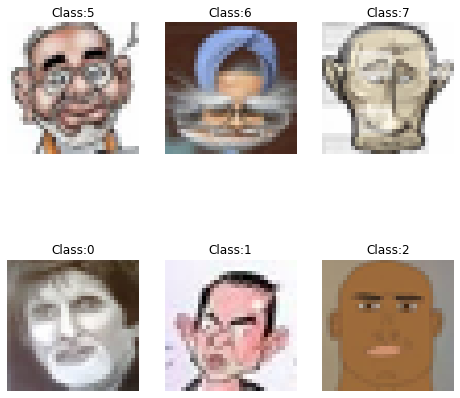

In [7]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

In [8]:
#flatten data
def flatten_data(X):
  num_images = X.shape[0]
  x_flatten = np.array([X[i].flatten() for i in range(num_images)])
  # x_flatten = x_flatten - np.average(x_flatten, axis=0)
  return x_flatten
  

In [9]:
x_flatten = flatten_data(X)
print(x_flatten.shape)

(672, 3072)


## Dimensionality Reduction
- Plot eigen spectrum for the data.

Percentage of variance preserved is defined as the fraction of eigen values used. As we include more principal components to describe the data, the percentage of variances preserved under the dimensionality reduction increases. 

- Plot the percentage of variances vs the number of principal components to validate the above statement.
- Try visualizing these eigen vectors. Comment on what these ghost faces represent 
- Try reconstructing images with your choice of number of principal components and visualize the reconstructed image.

Let's define reconstruction error as the frobenius norm of the difference between original and reconstructed image. 

- Plot the number of principal components vs the corresponding reconstruction error for 5 selected number of principal components of your choice.
- Using the two dominant principal values, plot the data with colors showing the labels. What do you observe?


#### Write a function that gives eigen values and eigen vectors given data

In [10]:
# write function
def eigenval_eigenvec(x):
  # calculating covariance matrix
  cov_mat = np.cov(x,rowvar=False)
  eigenvalues, eigenvectors = eigh(cov_mat)
  return eigenvalues, eigenvectors

def sort_eigenval(eigenvalues, eigenvectors):
  sorted_idx = np.argsort(eigenvalues[::-1])
  #sort the eigenvalues
  sorted_eigenvalue = eigenvalues[sorted_idx]
  #sort the eigenvectors 
  sorted_eigenvectors = eigenvectors[:,sorted_idx]
  return sorted_eigenvalue, sorted_eigenvectors


In [11]:
eigenvalues, eigenvectors = eigenval_eigenvec(x_flatten)
eigenvalues, eigenvectors = sort_eigenval(eigenvalues, eigenvectors)

In [12]:
eigenvalues.shape

(3072,)

#### Compute eigen values and plot eigen value spectrum

In [13]:

def get_interpolant(x,xp,fp):
  return np.interp(x,xp,range(fp))

# eigen values and spectrum
def plot_spectrum(eigenvalues,xlabel="",ylabel="",title="",type="bar",u_range=40):
  k = [i for i in range(1,u_range+1)]
  #bar plot
  if type=="bar":
    plt.figure(figsize=(12,6))
    plt.xticks(np.arange(1,u_range+1,1))
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.bar(k,eigenvalues[0:u_range])
  
  #line plot
  elif type=="plot":
    plt.plot(k,eigenvalues[0:u_range])
    x = 0.9
    x1 = get_interpolant(x,eigenvalues[0:u_range],u_range)
    val = round(x1)
    plt.annotate(str(round(x1)),(x1,x),xytext=(x1-10,x))
    plt.axhline(y = x, color = 'r', linestyle = '--')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    return val


  plt.show()



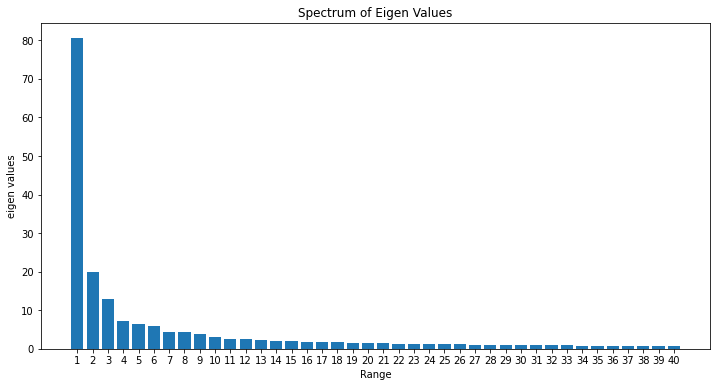

In [14]:
plot_spectrum(eigenvalues, xlabel="Range",ylabel="eigen values",title="Spectrum of Eigen Values")

#### Plot the percentage of variances vs the number of principal components

In [15]:
# plot variance vs components"
def variance(eigenvalues):
  cumulative_eigenvalues = np.cumsum(eigenvalues)
  var_eigenvalues = cumulative_eigenvalues/np.sum(eigenvalues)
  return var_eigenvalues

In [16]:
var_eigenvalues = variance(eigenvalues)

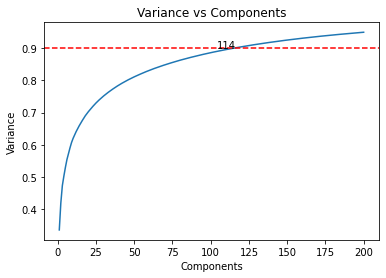

In [17]:
entire_dataset_comp = plot_spectrum(var_eigenvalues, xlabel="Components",ylabel="Variance", title="Variance vs Components", type="plot", u_range=200)

#### Visualize eigen faces(eigen vectors)

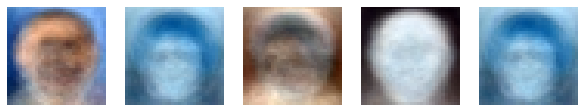

In [18]:
#Use the below sample code to visualize the eigen faces and reconstructed images (can write your own function as well)

def plot(image,H,W,C,indices):
    # indices = [randrange(100)+1 for i in range(5)]
    pl = np.reshape(image.T,(-1,H,W,C))
    plt.figure(figsize=(25,25))
    for c,i in enumerate(indices):
        ele = pl[i]
        minim = np.min(ele)
        maxim = np.max(ele)
        ele = (ele - minim) / (maxim - minim)
        ele = np.clip(ele,0,254)
        plt.subplot(1,12,c+1)
        plt.axis('off')
        plt.imshow(ele,cmap=plt.cm.gray)
    plt.show()

indices = [randrange(12)+1 for i in range(5)]
plot(eigenvectors,H,W,C, indices)


#### Reconstruction 

In [19]:
def reconstruction(x_flatten,eigenvectors, n_components):
  sub_eigenvectors = eigenvectors[:,0:n_components]
  sub_eigenvectors_sq = np.matmul(sub_eigenvectors,sub_eigenvectors.transpose())
  final_mat = np.matmul(x_flatten,sub_eigenvectors_sq)
  return final_mat

def calc_error(x_orig, x_recons):
  num_sample = x_orig.shape[0]
  error = norm(np.subtract(x_orig,x_recons),ord='fro')/num_sample
  return error
  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[]

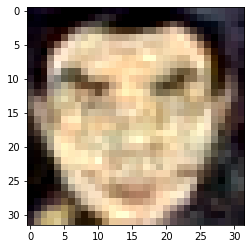

In [20]:
# reconstruction
n_components = 114
# sub_eigenvectors = eigenvectors[:,0:n_components]
# sub_eigenvectors_sq = np.matmul(sub_eigenvectors,sub_eigenvectors.transpose())
# final_mat = np.matmul(x_flatten,sub_eigenvectors_sq)
final_mat = reconstruction(x_flatten,eigenvectors, n_components)
temp = final_mat[1]
temp= temp.real
plt.imshow(temp.reshape(32,32,3))
plt.plot()


##Frobenius norm of the difference between original and reconstructed image.

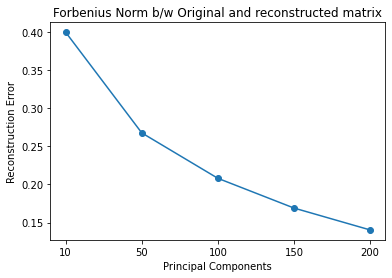

In [21]:
# Difference between original and reconstructed matrix
principal_components = [10,50,100,150,200]
error=list()
for i in principal_components:
  recons_mat = reconstruction(x_flatten,eigenvectors,i)
  error.append(calc_error(x_flatten,recons_mat))


plt.plot(list(map(str,principal_components)),error,marker='o')
plt.xlabel("Principal Components")
plt.ylabel("Reconstruction Error")
plt.title("Forbenius Norm b/w Original and reconstructed matrix")
plt.show()

#### Plot data in 2D

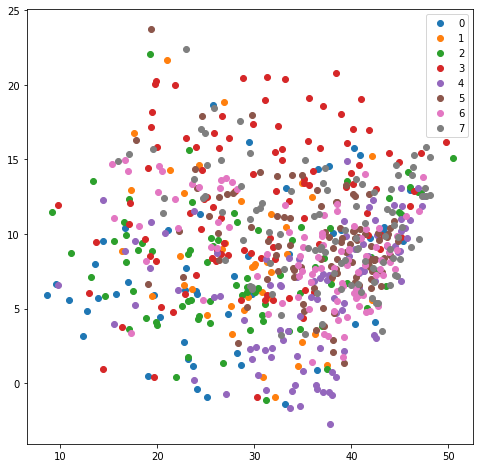

In [22]:
# plot data in 2D
unique_labels = np.unique(y)
sub_eigenvectors = eigenvectors[:,0:2]
plot_data = np.dot(x_flatten,sub_eigenvectors)
plt.figure(figsize=(8,8))
for i in unique_labels:
    temp = (y==i)
    plt.scatter(plot_data[temp , 0] , plot_data[temp , 1] , label = i)
plt.legend()
plt.show()

## Lets analyze the principal components classwise
- Visualize dominant eigen faces of each of the classes.
- Print the number of principal components required to retain 90% variance for each of the classes and for the entire dataset
- Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

Example output:
```
Number of principal components required for 90% reconstruction of the:
Entire Dataset = 10 
Amitabhbachan = 10
AamirKhan = 10
...
```

In [23]:
# Load data again
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


In [24]:
def process_data(X,y,unique_keys):
  # storing data for each labels in dict
  class_dict = {k:list() for k in unique_keys}

  for i in range(len(y)):
    class_dict[y[i]].append(X[i])
  
  # flattening the read data
  flat_dict = {k:None for k in unique_keys}
  for i in class_dict.keys():
    flat_dict[i] = flatten_data(np.array(class_dict[i]))
  
  return flat_dict


In [25]:
unique_keys = np.unique(y)
class_dict = process_data(X,y,unique_keys)
# for i in class_dict.keys():
#   print(class_dict[i].shape)

In [26]:
eigenvalues_dict = {k:None for k in unique_keys}
eigenvectors_dict = {k:None for k in unique_keys}
for i in unique_keys:
  eigenvalues_dict[i],eigenvectors_dict[i] = eigenval_eigenvec(class_dict[i])
  eigenvalues_dict[i],eigenvectors_dict[i] = sort_eigenval(eigenvalues_dict[i],eigenvectors_dict[i])

#### Visualize dominant eigen faces of each of the classes

Class  0
Dominant Eigen Faces


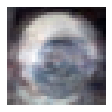


Class  1
Dominant Eigen Faces


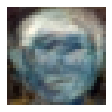


Class  2
Dominant Eigen Faces


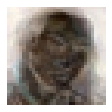


Class  3
Dominant Eigen Faces


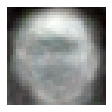


Class  4
Dominant Eigen Faces


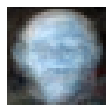


Class  5
Dominant Eigen Faces


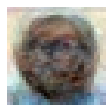


Class  6
Dominant Eigen Faces


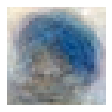


Class  7
Dominant Eigen Faces


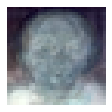

In [36]:
# visualize
y_interp = 0.9
u_range=200
k = [i for i in range(1,u_range+1)]
class_comp =list()
for i in unique_keys:
  eigenvalues_dict[i] = variance(eigenvalues_dict[i])
  x2 =get_interpolant(y_interp, eigenvalues_dict[i][:], 3072)
  class_comp.append(round(x2))
  print("Class ", i)
  print("Dominant Eigen Faces")
  plot(eigenvectors_dict[i],H,W,C, [0])
  print()

#### Number of principal components required to retain 90% variance for each of the classes and for the entire dataset

In [28]:
# components required
print("Number of principal components required for 90% reconstruction of the:")
print("Entire Dataset = " + str(entire_dataset_comp))
for i in cfw_dict.keys():
  print(i , "=", class_comp[cfw_dict[i]])

Number of principal components required for 90% reconstruction of the:
Entire Dataset = 114
Amitabhbachan = 20
AamirKhan = 23
DwayneJohnson = 26
AishwaryaRai = 35
BarackObama = 42
NarendraModi = 55
ManmohanSingh = 49
VladimirPutin = 43


#### Analysis : Are the number of components same for entire dataset and each of the classes. If yes why? If not why?

Number of components are not same for enitre dataset and each of classes due to the following reasons:
* In case of class wise PCA, we have all images which share the main features corresponding to same person and hence we require less number of components.

* In case of the entire dataset, the features contains 8 class and data is more generic thus to identify different classes and get more data we need more components.


In [29]:
# observation/analysis


## Linear Regression (continued)
1. Perform linear regression on below datapoints
2. Use PCA for dimensionality reduction on this datapoints and then perform Linear regression.
3. Perform this experiment on different number of components and report the score for linear regression. Plot the graph of [1-200] principal components vs regression score. What do you observe?

Note :- Can use inbuilt functions for Linear Regression and PCA for this question

In [30]:
# datapoints
X,y = load_data(dirpath)
X = X.reshape((X.shape[0],-1))
label = np.array([randrange((32*32*3)) for i in range(5)])
label = np.mean(X[:,label], axis = 1)
print(label.shape)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
(672,)


In [31]:
# code here
regression_score = list()
i = 1
while i < 201:
  pca = PCA(n_components=i)
  pca_x = pca.fit_transform(X)
  x_train,x_test,y_train,y_test = train_test_split(pca_x,label,test_size=0.2)
  model = LinearRegression()
  model.fit(x_train,y_train)
  temp_score = model.score(x_test,y_test)
  regression_score.append(temp_score)
  i+=1

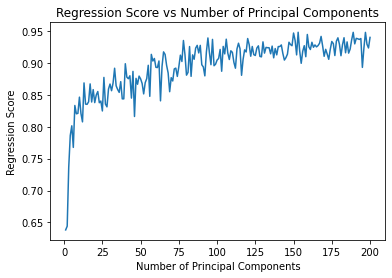

In [32]:
# analysis / plot (split the cells if required)
x_axis = range(1,201)
plt.plot(x_axis, regression_score)
plt.ylabel("Regression Score")
plt.xlabel("Number of Principal Components")
plt.title("Regression Score vs Number of Principal Components")
plt.show()

As from graph we can see regression score increases with number of components which tell us that with increase with components distance between the compnents is decreasing and more features are present for fitting in the model and it can preduct label of image with more accuracy.